In [1]:
%matplotlib inline


import scipy.io as sio
import numpy as np
from nilearn import plotting 
import pandas as pd
import seaborn as sns

/home/finc/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
top_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/'

In [3]:
mat = sio.loadmat('/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/multilayer_results_3/modules.mat')
allegiance = mat['modules']

In [4]:
allegiance.shape

(46, 4, 264, 20)

In [5]:
AM = np.zeros((46, 4, 264, 264))

In [6]:
for sub in range(len(allegiance[:,0,0,0])):
    for ses in range(len(allegiance[0,:,0,0])):
        for i in range(len(allegiance[0,0,:,0])):
            for j in range(len(allegiance[0,0,:,0])):
                vector = allegiance[sub, ses, i, :] == allegiance[sub, ses, j, :]
                M = vector.mean()
                AM[sub, ses, i, j] = M;

        

In [7]:
AMx = np.zeros((46, 4, 264, 264))

for i in range(46):
    for j in range(4):
        x = AM[i,j,:,:]
        np.fill_diagonal(x, 0)
        AMx[i,j,:,:] = x
        
AM = AMx


In [8]:
x = AM.mean(axis = 0)
#y = x.mean(axis = 0)
x.shape

#plotting.plot_matrix(x)

(4, 264, 264)

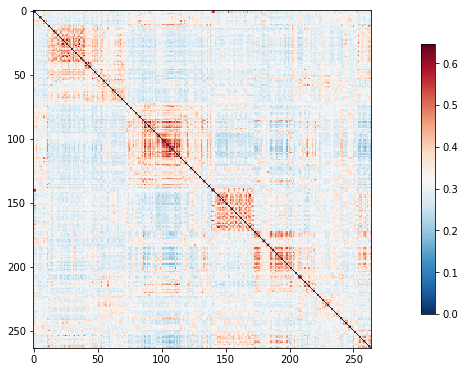

In [9]:
plotting.plot_matrix(x[0,:,:])

In [10]:
modules = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/code/modules.txt', sep = " ", header = None)
#modules = modules[0].values
network_pal = (sns.husl_palette(13))
network_lut = dict(zip(map(str, modules[0].unique()), network_pal))
network_lut

{'AU': [0.6280838378584804, 0.6317149736053096, 0.19371846323785552],
 'CER': [0.9538763597142671, 0.3594595647605631, 0.95756585161213],
 'CO': [0.756593795426372, 0.58660455674609, 0.19460548454202936],
 'DA': [0.9637107389395935, 0.4095260281088575, 0.7436447221919831],
 'DM': [0.44127702936426016, 0.6747986506725627, 0.19278677787286805],
 'FP': [0.2218708221705632, 0.6590814541823624, 0.7990680761766646],
 'MEM': [0.19925855442314272, 0.6935861010390585, 0.4349484671340832],
 'SAL': [0.38670894369284947, 0.6148978276981065, 0.9585912355668605],
 'SOM': [0.9218528551477546, 0.5003454332640002, 0.1960624705339954],
 'SUB': [0.7049741506310939, 0.5248938690186019, 0.9581527270311664],
 'UNC': [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 'VA': [0.20730980534421067, 0.6820252887361699, 0.5931178995944008],
 'VIS': [0.213603436221035, 0.6724447149771248, 0.6900417229996091]}

In [283]:
#networks = modules.columns.get_level_values(0)
#network_colors = pd.Series(modules, index=modules.columns).map(network_lut)

In [11]:
network_colors = pd.Series(modules[0]).map(network_lut)
network_colors = network_colors.tolist()
network_colors


[[0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9218528551477546, 0.5003454332640002, 0.1960624705339954],
 [0.9218528551477546, 0.5003454332640002, 0.1960624705339954],
 [0.9218528551477546, 0.5003454332640002, 0.1960624705339954],
 [0.9218528551477546, 0.5003454332640002, 0

In [12]:
# trying with sorting

modules = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/code/modules.txt', sep = " ", header = None)
#modules = modules[0].values
idx = np.argsort(modules[0])
modules= modules[0][idx]

network_pal = (sns.husl_palette(13))
network_lut = dict(zip(map(str, modules.unique()), network_pal))
network_lut

network_colors = pd.Series(modules).map(network_lut)
network_colors = network_colors.tolist()
network_colors


[[0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 [0.9218528551477546, 0.5003454332640002, 0.1960624705339954],
 [0.9218528551477546, 0.5003454332640002, 0.1960624705339954],
 [0.9218528551477546, 0.5003454332640002, 

In [ ]:

coords = zip(indices[0], indices[1])


In [14]:
y = x[:,:,idx]
z = y[:,idx,:]

In [15]:

z.shape

(4, 264, 264)

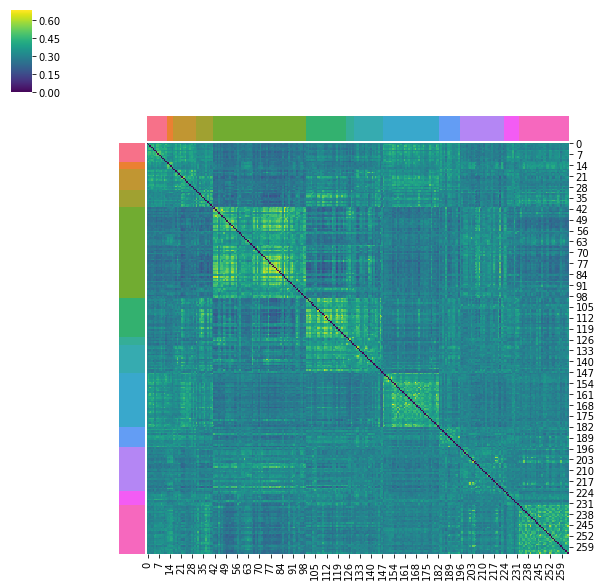

In [16]:
import seaborn as sns

sns.clustermap(z[3,:,:], cmap="viridis",row_cluster=False, col_cluster=False,
               row_colors=network_colors, col_colors=network_colors)

In [17]:
# Selecting subjects who finished the study

groups = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/data/behavioral/group_assignment.csv')

trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]

experimental = (trained_subs == 'Experimental')
control = (trained_subs == 'Control')

exp_vector = experimental['group'].values
con_vector = control['group'].values

In [18]:
experimental = AM[exp_vector,:,:,:]

exp_sess = experimental.mean(axis = 0)

In [19]:
u = exp_sess[:,:,idx]
p = u[:,idx,:]

p.shape

(4, 264, 264)

In [20]:
control = AM[con_vector,:,:,:]
con_sess = control.mean(axis = 0)

r = con_sess[:,:,idx]
s = r[:,idx,:]

s.shape

(4, 264, 264)

In [21]:
experimental.shape

(23, 4, 264, 264)

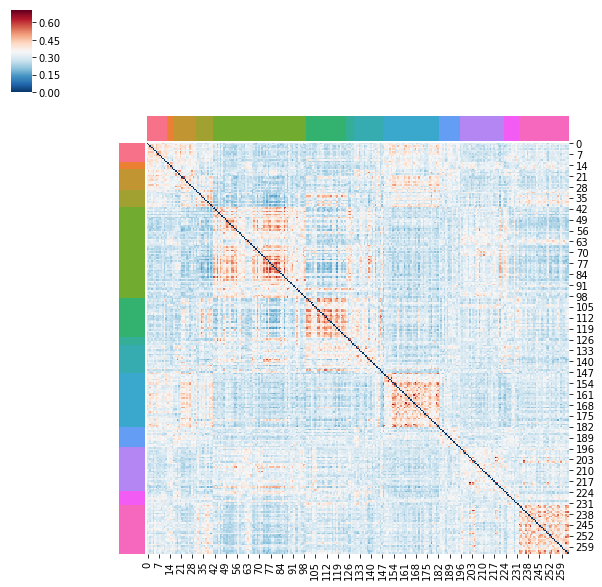

In [31]:
import seaborn as sns

sns.clustermap(p[0,:,:], cmap="RdBu_r",row_cluster=False, col_cluster=False,
               row_colors=network_colors, col_colors=network_colors)

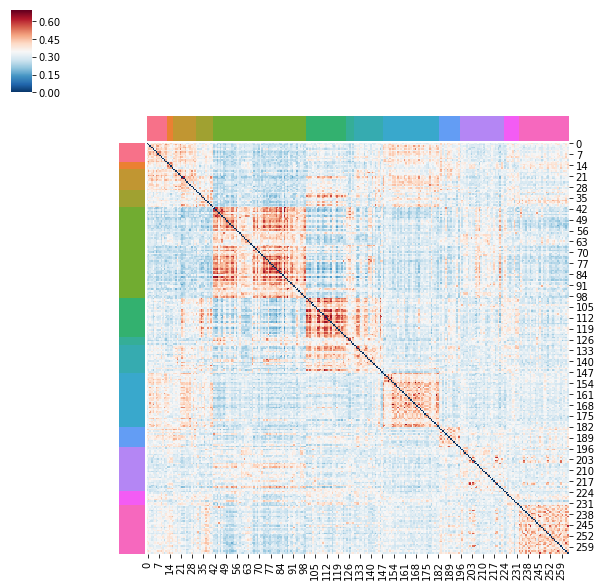

In [176]:
import seaborn as sns

sns.clustermap(p[3,:,:], cmap="RdBu_r",row_cluster=False, col_cluster=False,
               row_colors=network_colors, col_colors=network_colors)

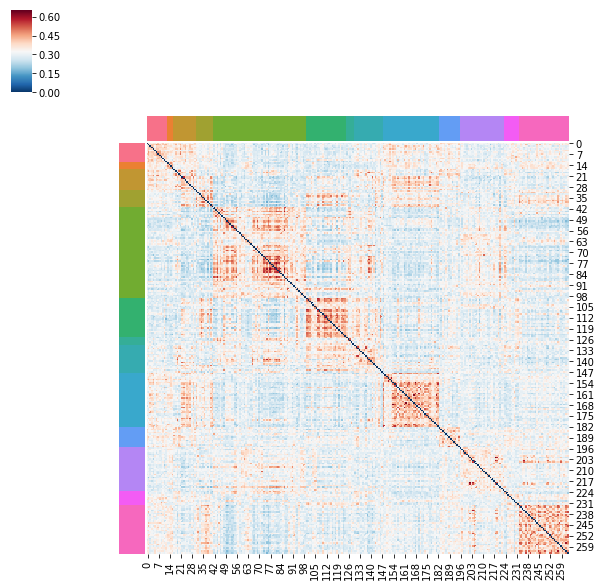

In [174]:
import seaborn as sns

sns.clustermap(p[0,:,:], cmap="RdBu_r",row_cluster=False, col_cluster=False,
               row_colors=network_colors, col_colors=network_colors)

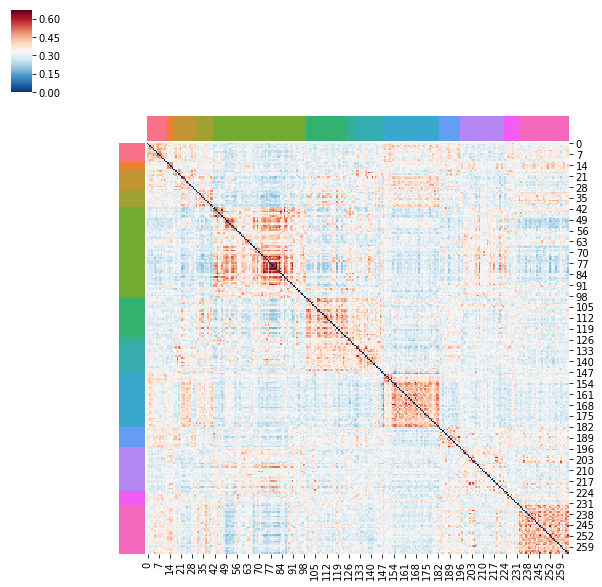

In [60]:
import seaborn as sns

sns.clustermap(s[3,:,:], cmap="RdBu_r",row_cluster=False, col_cluster=False,
               row_colors=network_colors, col_colors=network_colors)

In [32]:
mod = modules.reset_index(drop=True)

DMFP = (mod == 'DM')|(mod == 'FP')
DM = (mod == 'DM')
FP = (mod == 'FP')

sum(DMFP)

83

In [33]:
experimental = AM[con_vector,:,:,:]


In [70]:
experimental.shape

(23, 4, 264, 264)

In [34]:
u = experimental[:,:,:,idx]
e = u[:,:,idx,:]
e.shape

(23, 4, 264, 264)

In [35]:
dmfp = e[:,:,DMFP,:]
dmfp = dmfp[:,:,:,DMFP] 
dmfp.shape


mean_dmfp = dmfp.mean(axis = 0)
mean_dmfp.shape

(4, 83, 83)

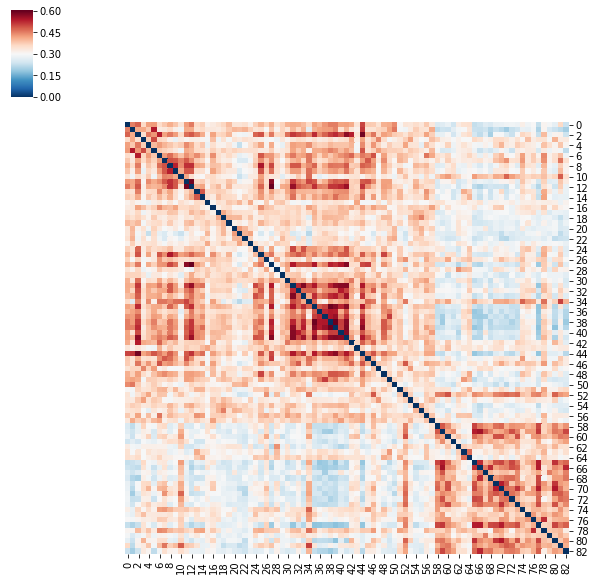

In [40]:
sns.clustermap(mean_dmfp[0,:,:], cmap="RdBu_r",row_cluster=False, col_cluster=False)

In [3]:
sns.clustermap(mean_dmfp[3,:,:], cmap="viridis",row_cluster=False, col_cluster=False)

NameError: name 'sns' is not defined

In [41]:
AMs = AM[:,:,idx,:]
AMsort = AMs[:,:,:,idx]

In [41]:
plotting.plot_matrix(c[0,:,:])

NameError: name 'c' is not defined

In [42]:
dm = AMsort[:,:,DM,:]
dm = dm[:,:,:,DM] 
dm.shape

mean_dm = dm.mean(axis = 2)
mean_dm = mean_dm.mean(axis = 2)

mean_dm.shape 
#mean_dm = dmp.mean(axis = 0)
#mean_dmfp.shape

mean_dm = pd.DataFrame(mean_dm)
mean_dm


,0,1,2,3
0,0.335553,0.369441,0.359929,0.356272
1,0.388763,0.395541,0.457015,0.331897
2,0.396730,0.438674,0.372384,0.397800
3,0.417747,0.364982,0.388080,0.401427
4,0.407402,0.408621,0.466617,0.403775
5,0.364477,0.405916,0.522562,0.445987
6,0.351011,0.353002,0.353954,0.348781
7,0.343371,0.452378,0.342985,0.358264
8,0.442479,0.373246,0.362128,0.500327
9,0.325803,0.360345,0.366677,0.368222


In [43]:
dm_i = AMsort[:,:,DM,:]
dm_i = dm_i[:,:,:,FP] 
dm_i.shape

mean_dm_i = dm_i.mean(axis = 2)
mean_dm_i = mean_dm_i.mean(axis = 2)

mean_dm_i.shape 
#mean_dm = dmp.mean(axis = 0)
#mean_dmfp.shape

mean_dm_i = pd.DataFrame(mean_dm_i)
mean_dm_i


,0,1,2,3
0,0.316931,0.285069,0.346586,0.279862
1,0.286690,0.279414,0.297966,0.272724
2,0.298207,0.271621,0.292069,0.285655
3,0.314069,0.300310,0.289621,0.325517
4,0.335621,0.327931,0.317103,0.308414
5,0.327759,0.277690,0.339966,0.280345
6,0.305862,0.309690,0.315517,0.309724
7,0.320172,0.246414,0.315517,0.303621
8,0.268862,0.264103,0.264759,0.242276
9,0.314517,0.326621,0.325345,0.284897


In [118]:
dm_i.shape

(23, 4, 58, 25)

In [91]:
AM.shape

(46, 4, 264, 264)

In [44]:
groups = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/data/behavioral/group_assignment.csv')

trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]
trained_subs = trained_subs.reset_index(drop=True)

trained_subs


dmn_recruit = pd.concat([trained_subs, mean_dm], axis = 1)
dmn_integr = pd.concat([trained_subs, mean_dm_i], axis = 1)

In [45]:
dmn_recruit.to_csv(top_dir + 'dmn_recruit_new.csv', index=False)
dmn_integr.to_csv(top_dir + 'dmn_integr_new.csv', index=False)


In [123]:
dmn_integr

,sub,group,0,1,2,3
0,sub-01,Control,0.316103,0.332103,0.362828,0.304448
1,sub-02,Control,0.297862,0.303862,0.268586,0.288655
2,sub-04,Control,0.306931,0.288310,0.299103,0.311655
3,sub-05,Experimental,0.295552,0.334448,0.304724,0.274276
4,sub-06,Experimental,0.339483,0.343276,0.314207,0.302931
5,sub-07,Experimental,0.333103,0.302448,0.324759,0.295172
6,sub-08,Control,0.299138,0.317172,0.315517,0.309379
7,sub-10,Control,0.302483,0.284897,0.310690,0.324724
8,sub-11,Experimental,0.291241,0.274379,0.297207,0.259655
9,sub-12,Control,0.312138,0.349379,0.285828,0.307172


In [46]:
fp = AMsort[:,:,FP,:]
fp = fp[:,:,:,FP] 
fp.shape

mean_fp = fp.mean(axis = 2)
mean_fp = mean_fp.mean(axis = 2)

mean_fp.shape 
#mean_fp = fp.mean(axis = 0)
#mean_dmfp.shape

mean_fp = pd.DataFrame(mean_fp)
mean_fp

,0,1,2,3
0,0.38800,0.41120,0.37920,0.45440
1,0.41328,0.44768,0.41136,0.35136
2,0.37360,0.41584,0.37248,0.37024
3,0.40704,0.43792,0.37888,0.41456
4,0.38624,0.41616,0.49392,0.45824
5,0.46976,0.47376,0.43632,0.48432
6,0.33712,0.36048,0.35968,0.42720
7,0.38160,0.38928,0.33920,0.34416
8,0.41568,0.45296,0.38416,0.45440
9,0.37584,0.38544,0.36416,0.39568


In [47]:
fpn_recruit = pd.concat([trained_subs, mean_fp], axis = 1)
fpn_recruit.to_csv(top_dir + 'fpn_recruit_new.csv', index=False)
